Cryptography

Tagging along with Polylog and Claude

References:

[I can prove I’ve solved this Sudoku without revealing it - Polylog](https://youtu.be/Otvcbw6k4eo?si=0PMUnGsDrkqXEeVc)

Tutor:

Anthropic's AI Claude

Zero knowledge proofs were first introduced in the 1980s by Shafi Goldwasser, Silvio Micali, and Charles Rackoff, and have become increasingly important in modern cryptography, particularly for applications like blockchain technology, secure authentication systems, and privacy-preserving protocols.

Zero knowledge proof approach for proving that a 6-node, 7-edge graph has a proper vertex coloring (no adjacent nodes sharing the same color) without revealing the actual coloring.

Here's a potential approach using a commitment-based protocol:

## Zero Knowledge Proof for Graph Coloring

This proof allows a prover to convince a verifier that they know a valid 3-coloring of the graph without revealing which colors are assigned to which nodes.

### Setup:
1. The prover has a valid 3-coloring of the graph using colors {1, 2, 3}
2. Both parties agree on the graph structure (6 nodes, 7 edges)
3. Both parties agree on a secure cryptographic commitment scheme

### Protocol:

1. **Commitment Phase**:
   - The prover randomly permutes the three colors (e.g., 1→2, 2→3, 3→1)
   - For each node i, the prover computes a commitment C(i) to the (permuted) color of node i
   - The prover sends all commitments to the verifier

2. **Challenge Phase**:
   - The verifier randomly selects an edge (u,v) from the graph
   - The verifier asks the prover to reveal the colors of nodes u and v

3. **Response Phase**:
   - The prover opens the commitments C(u) and C(v), revealing the colors
   - The verifier checks that the revealed colors are different

4. **Repeat**:
   - Steps 1-3 are repeated multiple times (with fresh permutations each time)

### Properties:

- **Completeness**: If the prover knows a valid coloring, they will always pass the verification
- **Soundness**: If the graph is not properly colored, the prover will be caught with probability at least 1/7 in each round (there are 7 edges)
- **Zero Knowledge**: Because the colors are randomly permuted in each round, the verifier learns only that the two nodes of the challenged edge have different colors, not what the actual coloring is

Running this protocol approximately 20 times would reduce the probability of a cheating prover succeeding to less than one in a million.

This approach is based on the seminal work by Goldreich, Micali, and Wigderson who showed that graph 3-coloring (and thus all NP problems) have zero-knowledge proofs.

Generated coloring: {1: 1, 2: 3, 3: 2, 4: 1, 5: 2, 6: 3}


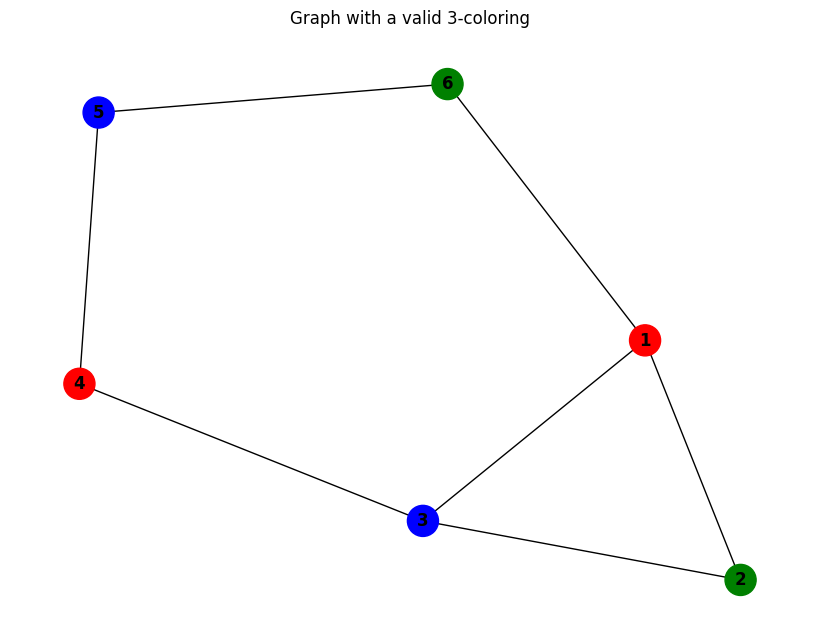

Starting ZKP protocol for graph coloring with 15 rounds
Graph has 6 nodes and 7 edges
Original coloring (known only to the prover):
Node 1: Color 1
Node 2: Color 3
Node 3: Color 2
Node 4: Color 1
Node 5: Color 2
Node 6: Color 3


Round 1:
Prover sends commitments for all nodes...
Verifier challenges edge (5, 6)
Prover reveals: Node 5 has color 2, Node 6 has color 1
Verification result: Passed


Round 2:
Prover sends commitments for all nodes...
Verifier challenges edge (2, 3)
Prover reveals: Node 2 has color 2, Node 3 has color 3
Verification result: Passed


Round 3:
Prover sends commitments for all nodes...
Verifier challenges edge (5, 6)
Prover reveals: Node 5 has color 1, Node 6 has color 2
Verification result: Passed


Round 4:
Prover sends commitments for all nodes...
Verifier challenges edge (5, 6)
Prover reveals: Node 5 has color 3, Node 6 has color 1
Verification result: Passed


Round 5:
Prover sends commitments for all nodes...
Verifier challenges edge (3, 4)
Prover reveals:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import hashlib
import hmac
import secrets as secrets_module

class GraphColoringZKP:
    def __init__(self, graph):
        """Initialize with a graph"""
        self.graph = graph
        self.num_nodes = len(graph.nodes())
        self.num_edges = len(graph.edges())
        # For visualization
        self.pos = nx.spring_layout(self.graph, seed=42)

    def generate_coloring(self):
        """Generate a valid coloring for the graph"""
        # Using a greedy algorithm to color the graph
        nodes = list(self.graph.nodes())
        # Sort nodes by degree in descending order (Welsh-Powell algorithm)
        nodes.sort(key=lambda x: self.graph.degree(x), reverse=True)

        # Initialize all nodes with no color
        self.coloring = {node: None for node in self.graph.nodes()}

        # Available colors (1, 2, 3)
        colors = [1, 2, 3]

        # Color each node
        for node in nodes:
            # Get colors of neighbors
            neighbor_colors = {self.coloring[neighbor] for neighbor in
                              self.graph.neighbors(node) if self.coloring[neighbor] is not None}

            # Find the first available color not used by any neighbor
            for color in colors:
                if color not in neighbor_colors:
                    self.coloring[node] = color
                    break

        # Force the use of 3 colors by ensuring we have at least one node of each color
        # Only if we're not using all 3 colors already
        used_colors = set(self.coloring.values())
        if len(used_colors) < 3:
            # Find colors not used
            unused_colors = [c for c in colors if c not in used_colors]

            # Find nodes that can have their color changed without violating constraints
            for unused_color in unused_colors:
                for node in self.graph.nodes():
                    neighbor_colors = {self.coloring[neighbor] for neighbor in self.graph.neighbors(node)}
                    if unused_color not in neighbor_colors:
                        self.coloring[node] = unused_color
                        break

        # Verify the coloring is valid
        if not self.verify_coloring(self.coloring):
            raise ValueError("Failed to generate a valid coloring")

        return self.coloring

    def verify_coloring(self, coloring):
        """Verify that the coloring is valid"""
        for edge in self.graph.edges():
            node1, node2 = edge
            if coloring[node1] == coloring[node2]:
                return False
        return True

    def visualize_coloring(self, coloring=None):
        """Visualize the graph with the given coloring"""
        if coloring is None:
            coloring = self.coloring

        color_map = {1: 'red', 2: 'blue', 3: 'green'}
        node_colors = [color_map[coloring[node]] for node in self.graph.nodes()]

        plt.figure(figsize=(8, 6))
        nx.draw(self.graph, self.pos, with_labels=True,
                node_color=node_colors, node_size=500, font_weight='bold')
        plt.title("Graph with a valid 3-coloring")
        plt.show()

    def commit(self, value, secret):
        """Create a commitment to a value using a secret"""
        combined = f"{value}:{secret}".encode()
        return hashlib.sha256(combined).hexdigest()

    def prove_round(self):
        """Execute a single round of the ZKP protocol as the prover"""
        # 1. Permute the colors
        permutation = list(range(1, 4))
        random.shuffle(permutation)
        color_map = {i: permutation[i-1] for i in range(1, 4)}

        # Map original colors to permuted colors
        permuted_coloring = {node: color_map[self.coloring[node]] for node in self.graph.nodes()}

        # 2. Generate commitments with random secrets
        node_secrets = {node: secrets_module.token_hex(16) for node in self.graph.nodes()}
        commitments = {node: self.commit(permuted_coloring[node], node_secrets[node])
                      for node in self.graph.nodes()}

        return {
            'permuted_coloring': permuted_coloring,
            'secrets': node_secrets,
            'commitments': commitments
        }

    def verify_round(self, round_data, edge):
        """Verify a single round of the ZKP protocol as the verifier"""
        node1, node2 = edge

        # Get the revealed values and secrets for the nodes of the challenged edge
        color1 = round_data['permuted_coloring'][node1]
        color2 = round_data['permuted_coloring'][node2]
        secret1 = round_data['secrets'][node1]
        secret2 = round_data['secrets'][node2]

        # Verify the commitments match
        commitment1 = round_data['commitments'][node1]
        commitment2 = round_data['commitments'][node2]

        valid_commitment1 = self.commit(color1, secret1) == commitment1
        valid_commitment2 = self.commit(color2, secret2) == commitment2

        # Check colors are different
        different_colors = color1 != color2

        return valid_commitment1 and valid_commitment2 and different_colors

    def run_protocol(self, num_rounds=10):
        """Run the full ZKP protocol for multiple rounds"""
        if not hasattr(self, 'coloring'):
            self.generate_coloring()

        edges = list(self.graph.edges())

        print(f"Starting ZKP protocol for graph coloring with {num_rounds} rounds")
        print(f"Graph has {self.num_nodes} nodes and {self.num_edges} edges")
        print("Original coloring (known only to the prover):")
        for node, color in self.coloring.items():
            print(f"Node {node}: Color {color}")
        print("\n")

        for round_num in range(1, num_rounds + 1):
            print(f"Round {round_num}:")

            # Prover's move: create commitments
            round_data = self.prove_round()
            print("Prover sends commitments for all nodes...")

            # Verifier's move: select a random edge to challenge
            challenged_edge = random.choice(edges)
            print(f"Verifier challenges edge {challenged_edge}")

            # Prover's response: reveal colors for the challenged edge
            node1, node2 = challenged_edge
            print(f"Prover reveals: Node {node1} has color {round_data['permuted_coloring'][node1]}, "
                  f"Node {node2} has color {round_data['permuted_coloring'][node2]}")

            # Verification
            result = self.verify_round(round_data, challenged_edge)
            print(f"Verification result: {'Passed' if result else 'Failed'}")
            print("\n")

            if not result:
                print("Protocol failed! The prover doesn't have a valid coloring.")
                return False

        # Calculate the confidence level
        confidence = 1 - (1/self.num_edges) ** num_rounds
        print(f"Protocol completed successfully with {num_rounds} rounds.")
        print(f"The verifier is {confidence*100:.6f}% confident that the prover knows a valid coloring.")
        return True


# Create a graph with 6 nodes and 7 edges that requires 3 colors
def create_test_graph():
    G = nx.Graph()
    G.add_nodes_from(range(1, 7))
    # This edge configuration creates a graph that requires 3 colors
    # Adding a triangle (1-2-3) + additional connections
    edges = [(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 6), (6, 1)]
    G.add_edges_from(edges)
    return G

# Run the demonstration
if __name__ == "__main__":
    # Create the graph
    G = create_test_graph()

    # Initialize the ZKP protocol
    zkp = GraphColoringZKP(G)

    # Generate and visualize a valid coloring
    coloring = zkp.generate_coloring()
    print("Generated coloring:", coloring)

    # Uncomment to visualize the graph coloring
    zkp.visualize_coloring()

    # Run the ZKP protocol
    zkp.run_protocol(num_rounds=15)